In [9]:
import os, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from ibmpairs import query, client
import ibmpairs.client as client
import ibmpairs.query as query
import json
import rasterio
import configparser
from IPython.display import display as display_summary
from IPython import display
import folium
import branca.colormap as cm
from matplotlib import colors as colors
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



In [10]:
# IBM Environmental Intelligence API Credentials
EI_API_KEY = "PHXl8QLvhVbvlZNxLblT7x6aedTPPRr9oF01OaPOkXX0kY"
EI_TENANT_ID = "4f6b0548-5329-429a-8acb-206e6c411b0b"
EI_ORG_ID = "552192e8-e412-4302-bfd4-76b5cb15680d"


In [11]:
# Initialize IBM API client
EI_client_v3 = client.get_client(api_key=EI_API_KEY, tenant_id=EI_TENANT_ID, org_id=EI_ORG_ID, version=3)


2025-03-06 10:37:26 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-03-06 10:37:26 - paw - INFO - Legacy Environment is False
2025-03-06 10:37:26 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-03-06 10:37:28 - paw - INFO - Authentication success.
2025-03-06 10:37:28 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


In [12]:
# Predefined Locations (lat_min, lon_min, lat_max, lon_max)
locations = {
    "New York": [40.65015, -74.21323, 40.83345, -73.95059],
    "Mumbai": [18.887, 72.751, 19.271, 72.986],
    "London": [51.282, -0.510, 51.691, 0.334],
    "Paris": [48.700, 2.150, 49.000, 2.600],
    "Venice": [45.370, 12.220, 45.490, 12.360]
}

In [13]:
# Function to dynamically get the area name (Replace this with an API call if needed)
def get_area_name(lat, lon):
    return f"Custom_{lat:.2f}_{lon:.2f}"

# User selects location or enters custom coordinates
print("Select a location or enter custom coordinates:")
for i, city in enumerate(locations.keys(), start=1):
    print(f"{i}. {city}")
print("6. Custom Location")

choice = input("Enter the number (1-6): ").strip()

if choice in ['1', '2', '3', '4', '5']:
    area_name = list(locations.keys())[int(choice) - 1]
    spatial_coordinates = locations[area_name]
else:
    lat = float(input("Enter latitude: "))
    lon = float(input("Enter longitude: "))
    area_name = get_area_name(lat, lon)
    spatial_coordinates = [lat - 0.05, lon - 0.05, lat + 0.05, lon + 0.05]
    print(f"Using dynamically detected area: {area_name}")
    


Select a location or enter custom coordinates:
1. New York
2. Mumbai
3. London
4. Paris
5. Venice
6. Custom Location


In [31]:
'''# Submit query to IBM Environmental Intelligence API
query_object = query.submit_check_status_and_download({
    "name": f"{area_name} area at risk of sea rise level",
    "layers": [
        {
            "type": "raster",
            "id": "49506",  # SRTM DEM (Digital Elevation Model)
            "temporal": {"intervals": [{"snapshot": "2024-01-01T00:00:00Z"}]},
            "output": True,
            "filter": {"operator": "GT", "value": "0"}
        }
    ],
    "spatial": {"type": "square", "coordinates": spatial_coordinates},
    "temporal": {"intervals": [{"snapshot": "2024-01-01T00:00:00Z"}]}
}, client=EI_client_v3)'''

# *Step 1: Query Data from 2025 to 2030 (Every 1 Year)*
time_intervals = pd.date_range("2025-01-01", "2030-01-01", freq="1Y").strftime("%Y-%m-%dT00:00:00Z").tolist()
risk_levels = []
risk_map_data = []

for timestamp in time_intervals:
    print(f"Fetching data for {timestamp}...")

    query_object = query.submit_check_status_and_download({
        "name": f"{area_name} sea level risk on {timestamp}",
        "layers": [
            {
                "type": "raster",
                "id": "49506",  # SRTM DEM (Digital Elevation Model)
                "temporal": {"intervals": [{"snapshot": timestamp}]},
                "output": True,
                "filter": {"operator": "GT", "value": "0"}
            }
        ],
        "spatial": {"type": "square", "coordinates": spatial_coordinates},
        "temporal": {"intervals": [{"snapshot": timestamp}]}
    }, client=EI_client_v3)


Fetching data for 2025-12-31T00:00:00Z...
2025-03-06 14:22:57 - paw - INFO - TASK: submit_check_status_and_download STARTING.


C:\Users\surya\AppData\Local\Temp\ipykernel_23900\2532397121.py:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  time_intervals = pd.date_range("2025-01-01", "2030-01-01", freq="1Y").strftime("%Y-%m-%dT00:00:00Z").tolist()


2025-03-06 14:22:58 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present; trying to refresh.
2025-03-06 14:22:58 - paw - INFO - Attempting to refresh authentication token.
2025-03-06 14:23:00 - paw - INFO - The token was successfully refreshed.
2025-03-06 14:23:01 - paw - INFO - The query was successfully submitted with the id: 1741219200_31982927.
2025-03-06 14:23:03 - paw - INFO - The query 1741219200_31982927 has the status Queued.
2025-03-06 14:23:34 - paw - INFO - The query 1741219200_31982927 has the status Succeeded.
2025-03-06 14:23:34 - paw - INFO - The query 1741219200_31982927 was successful after checking the status.
2025-03-06 14:24:05 - paw - INFO - The query 1741219200_31982927 has the status Succeeded.
2025-03-06 14:24:05 - paw - INFO - The query 1741219200_31982927 was successful after checking the status.
2025-03-06 14:24:05 - paw - INFO - The query download folder is set to the path c:\Users\surya\OneDri

In [15]:
# Function to get the bounding box extent from metadata
def get_extent(f):
    with open(f, "r") as ff:
        stats = json.load(ff)
    boundingBox = stats["boundingBox"]
    return [boundingBox["minLongitude"], boundingBox["maxLongitude"], boundingBox["minLatitude"], boundingBox["maxLatitude"]]


In [34]:
# Get raster files
result_rasterfiles_list = query_object.list_files()

for risk_file in result_rasterfiles_list:
        if risk_file.endswith('.tiff'):
            with rasterio.open(risk_file) as raster:
                data = raster.read(1)
                avg_risk = np.mean(data[data > 0])
                risk_levels.append(avg_risk)
                risk_map_data.append((spatial_coordinates[0], spatial_coordinates[1], avg_risk))  # (lat, lon, risk)
                print(f"Avg Sea Level Risk on {timestamp}: {avg_risk:.2f}")

Avg Sea Level Risk on 2029-12-31T00:00:00Z: 37.57


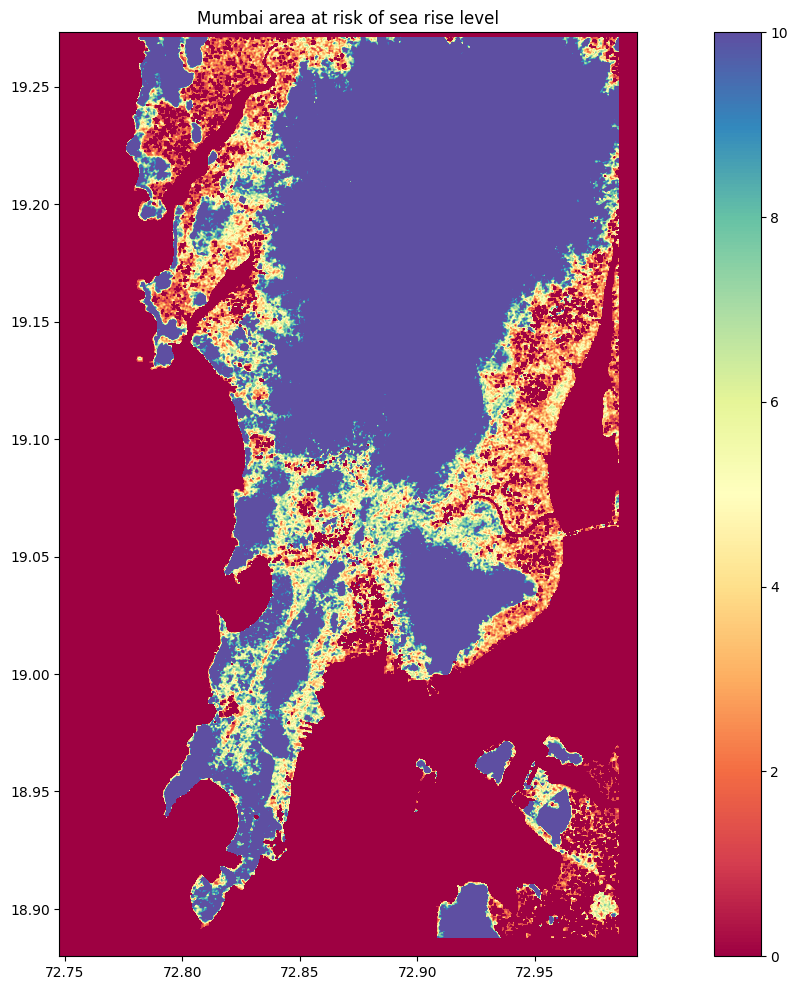

Saved: Mumbai_sea_risk.jpg


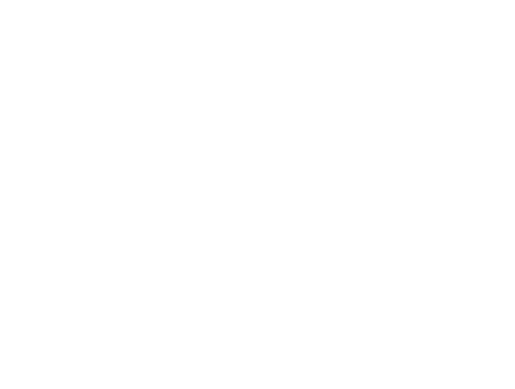

In [16]:
# Function to display raster data
def display_raster(raster_file_name, colorMap, title=None, Max=None, Min=None, myextent=None, savepng=True):
    if raster_file_name.endswith(".tiff"):
        with rasterio.open(raster_file_name) as raster_file:
            if not myextent:
                myextent = get_extent(raster_file_name + ".json")
            data = raster_file.read(1)
            fig = plt.figure(figsize=(20, 12))
            if Max is None:
                Max = data.max()
            if Min is None:
                Min = data.min()
            plt.imshow(data, cmap=colorMap, vmin=Min, vmax=Max, extent=myextent)
            if not title:
                title = os.path.basename(raster_file_name)
            plt.title(title)
            plt.colorbar()
            plt.show()
            if savepng:
                plt.axis('off')
                filename = f"{area_name}_sea_risk.jpg"
                fig.savefig(filename, bbox_inches='tight', pad_inches=0)
                print(f"Saved: {filename}")

# Retrieve raster files from the query results
result_rasterfiles_list = query_object.list_files()

for risk_file in result_rasterfiles_list:
    display_raster(risk_file, 'Spectral', title=f"{area_name} area at risk of sea rise level", Min=0, Max=10)

In [36]:
# Set Downloads folder
DOWNLOADS_DIR = os.path.join(os.path.expanduser("~"), "Downloads")
os.makedirs(DOWNLOADS_DIR, exist_ok=True)

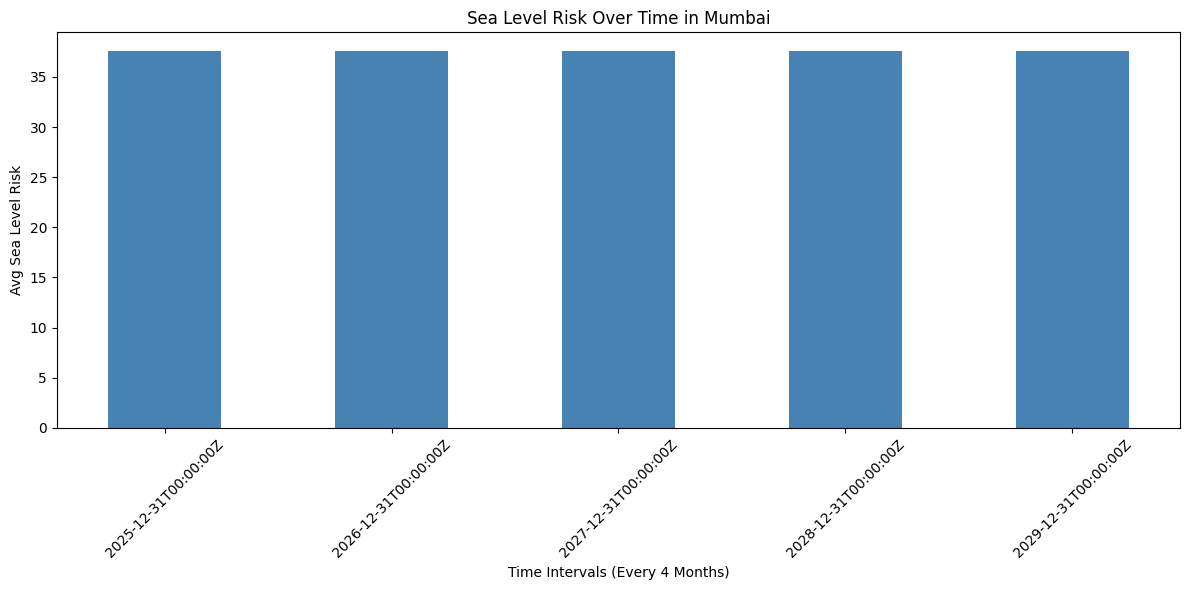

Saved Histogram: C:\Users\surya\Downloads\Mumbai_sea_risk_histogram.png


In [37]:
# *Step 2: Plot Histogram*
plt.figure(figsize=(12, 6))
plt.bar(time_intervals, risk_levels, color='steelblue', width=0.5)
plt.xticks(rotation=45)
plt.xlabel("Time Intervals (Every 4 Months)")
plt.ylabel("Avg Sea Level Risk")
plt.title(f"Sea Level Risk Over Time in {area_name}")
plt.tight_layout()

histogram_path = os.path.join(DOWNLOADS_DIR, f"{area_name}_sea_risk_histogram.png")
plt.savefig(histogram_path)
plt.show()
print(f"Saved Histogram: {histogram_path}")


In [17]:
# Generate map visualization
Max_risk_elevation = 20

def create_fast_colormap_for_range(mycmmap_choice, vmin, vmax, empty_val):
    cm_scale = mycmmap_choice.scale(vmin, vmax)
    cmArray = []
    for i in range(0, 255, 1):
        if i > vmax or i == empty_val:
            cmArray.insert(i, (1, 0, 0, 0))
        else:
            cmArray.insert(i, colors.to_rgba(cm_scale(i), 0.8))
    return cmArray

cmArray = create_fast_colormap_for_range(cm.linear.Spectral_07, 0, Max_risk_elevation, 0)

for risk_file in result_rasterfiles_list:
    if risk_file.endswith('.tiff'):
        with rasterio.open(risk_file) as raster:
            rb = raster.bounds
            Map = folium.Map(
                max_bounds=True,
                location=[(rb.bottom + rb.top) / 2, (rb.left + rb.right) / 2],
                zoom_start=9,
                min_lat=rb.bottom,
                max_lat=rb.top,
                min_lon=rb.left,
                max_lon=rb.right
            )
            Data = raster.read(1).astype(np.uint8)
            Data[Data > Max_risk_elevation] = 0

            folium.raster_layers.ImageOverlay(
                image=Data, opacity=0.7,
                colormap=lambda value: cmArray[value],
                bounds=[[rb.bottom, rb.left], [rb.top, rb.right]]
            ).add_to(Map)

            Map.add_child(cm.linear.Spectral_07.scale(0, Max_risk_elevation))

            # Save the map
            map_filename = f"{area_name}_risk_map.html"
            Map.save(map_filename)
            print(f"Saved: {map_filename}")

print("Processing complete.")

Saved: Mumbai_risk_map.html
Processing complete.


In [38]:
# *Step 3: Generate Map*
center_lat = (spatial_coordinates[0] + spatial_coordinates[2]) / 2
center_lon = (spatial_coordinates[1] + spatial_coordinates[3]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)
colormap = cm.LinearColormap(["blue", "yellow", "red"], vmin=min(risk_levels), vmax=max(risk_levels), caption="Sea Level Risk")

for lat, lon, risk in risk_map_data:
    folium.CircleMarker(
        location=[lat, lon],
        radius=8,
        color=colormap(risk),
        fill=True,
        fill_color=colormap(risk),
        fill_opacity=0.7,
        popup=f"Avg Risk: {risk:.2f}"
    ).add_to(m)

colormap.add_to(m)

# Save the map
map_path = os.path.join(DOWNLOADS_DIR, f"{area_name}_sea_risk_map.html")
m.save(map_path)
print(f"Saved Interactive Map: {map_path}")

print("Processing complete.")

Saved Interactive Map: C:\Users\surya\Downloads\Mumbai_sea_risk_map.html
Processing complete.


Saved: Mumbai_elevation_histogram.png


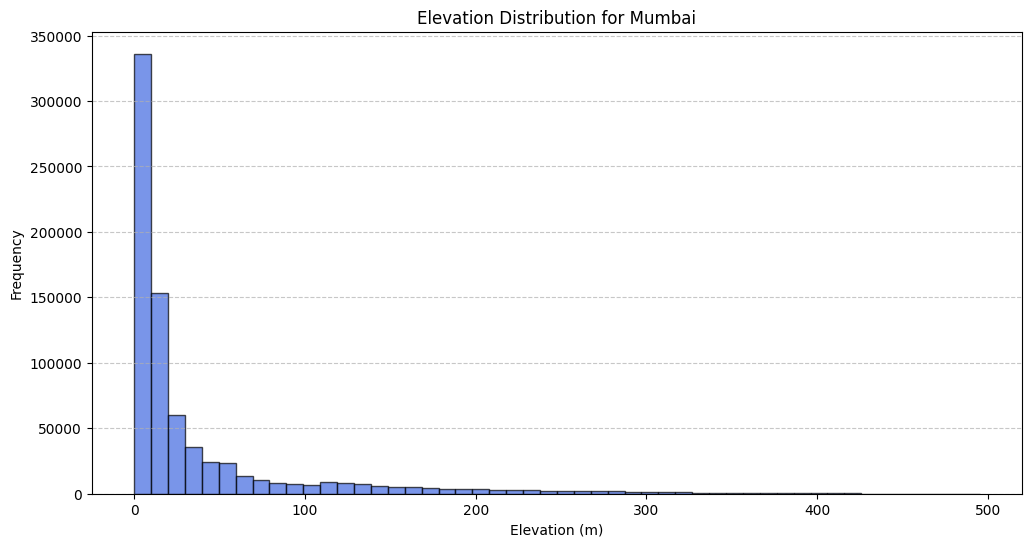

In [18]:
# Function to generate and display a histogram of raster elevation data
def plot_histogram(raster_file_name, bins=50):
    if raster_file_name.endswith(".tiff"):
        with rasterio.open(raster_file_name) as raster_file:
            data = raster_file.read(1).flatten()  # Flatten the array to 1D
            data = data[data > 0]  # Filter out zero or no-data values

            plt.figure(figsize=(12, 6))
            plt.hist(data, bins=bins, color='royalblue', alpha=0.7, edgecolor='black')

            plt.xlabel("Elevation (m)")
            plt.ylabel("Frequency")
            plt.title(f"Elevation Distribution for {area_name}")
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Save the histogram
            hist_filename = f"{area_name}_elevation_histogram.png"
            plt.savefig(hist_filename)
            print(f"Saved: {hist_filename}")

            plt.show()

# Call the function for each raster file
for risk_file in result_rasterfiles_list:
    plot_histogram(risk_file)

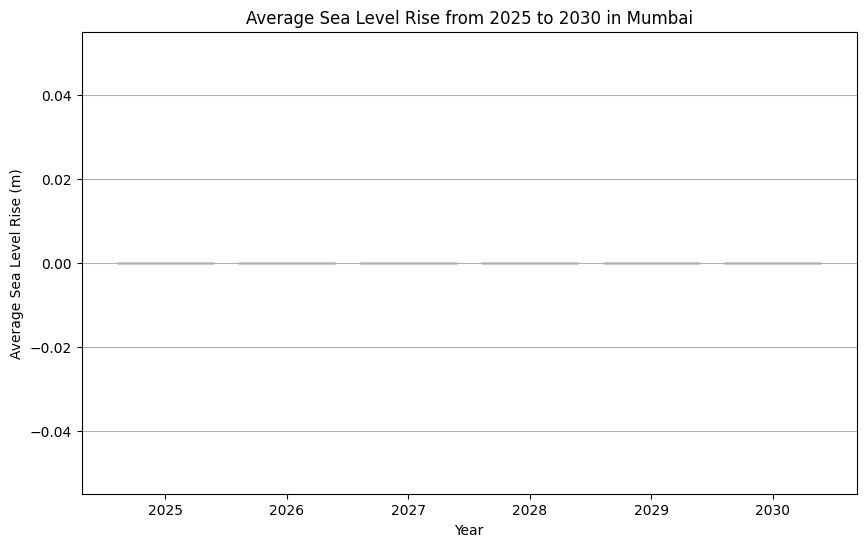

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate and plot average sea level rise over a year as a histogram
def plot_sea_level_rise_histogram(risk_map_data, area_name):
    yearly_averages = []
    years = list(range(2025, 2031))

    for year_data in risk_map_data:
        if isinstance(year_data, tuple):
            year_data = year_data[0]  # Extract the array if year_data is a tuple
        if isinstance(year_data, np.ndarray):
            valid_data = year_data[year_data > 0]  # Filter out non-positive values
            if valid_data.size > 0:
                yearly_avg = np.mean(valid_data)
                yearly_averages.append(yearly_avg)
            else:
                yearly_averages.append(0)  # Append 0 if no valid data is found
        else:
            yearly_averages.append(0)  # Append 0 if the data type is invalid

    plt.figure(figsize=(10, 6))
    plt.bar(years, yearly_averages, color='skyblue', edgecolor='black')
    plt.title(f"Average Sea Level Rise from 2025 to 2030 in {area_name}")
    plt.xlabel("Year")
    plt.ylabel("Average Sea Level Rise (m)")
    plt.grid(axis='y')
    plt.show()

# Example function call
plot_sea_level_rise_histogram(risk_map_data, area_name)

Saved: Mumbai_gaussian_risk_vs_elevation.png


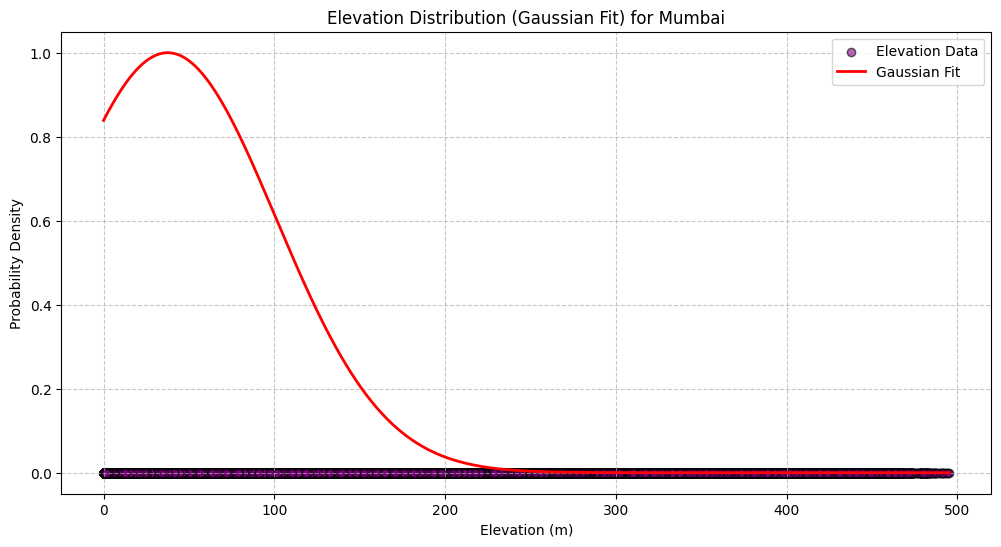

In [39]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm

def plot_risk_vs_elevation_gaussian(raster_file_name, bins=50):
    if raster_file_name.endswith(".tiff"):
        with rasterio.open(raster_file_name) as raster_file:
            # Read and preprocess elevation data
            data = raster_file.read(1).flatten()
            data = data[data > 0]  # Remove invalid values (e.g., negative elevations)

            # Normalize Elevation Data (optional, depending on your use case)
            scaler = MinMaxScaler()
            data = data.reshape(-1, 1)
            data_scaled = scaler.fit_transform(data).flatten()

            # Calculate Gaussian Fit
            mu, std = np.mean(data), np.std(data)
            x_values = np.linspace(np.min(data), np.max(data), 1000)  # Smooth range of elevation values
            gaussian_fit = norm.pdf(x_values, mu, std)  # Gaussian PDF for the elevation data

            # Normalize Gaussian Fit to [0, 1] (optional, for visualization)
            gaussian_fit_normalized = gaussian_fit / np.max(gaussian_fit)

            # Plot the data and Gaussian fit
            plt.figure(figsize=(12, 6))
            plt.scatter(data, np.zeros_like(data), color='purple', alpha=0.6, edgecolors='black', label='Elevation Data')
            plt.plot(x_values, gaussian_fit_normalized, color='red', linewidth=2, label='Gaussian Fit')

            plt.xlabel("Elevation (m)")
            plt.ylabel("Probability Density")
            plt.title(f"Elevation Distribution (Gaussian Fit) for {area_name}")
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()

            # Save the plot
            gaussian_filename = f"{area_name}_gaussian_risk_vs_elevation.png"
            plt.savefig(gaussian_filename)
            print(f"Saved: {gaussian_filename}")

            plt.show()

# Call the function
for risk_file in result_rasterfiles_list:
    plot_risk_vs_elevation_gaussian(risk_file)

In [41]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler

# Load the CSV file into a DataFrame
df = pd.read_csv('500-041_50yr.csv')

# Interpolate missing values in both directions
df_interpolated = df.interpolate(limit_direction='both')

# Drop the 'Linear Trend' column
df_interpolated = df_interpolated.drop(columns=[' Linear Trend'])

# Extract extra features (not used for prediction)
extra_features = df_interpolated[[' Upper95%', ' Lower95%']]

# Prepare the data
X = df_interpolated[['Trend Year']].values  # Only use Year as an independent variable
y = df_interpolated[' Trend in mm'].values.reshape(-1, 1)  # Dependent variable (Sea level rise)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create sequences for LSTM input
def create_sequences(X, y, seq_length=3):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i: i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 3
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Reshape X_seq for Conv1D (adding a single feature dimension)
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

# Build the CNN-Bidirectional LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, 1)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model with validation split
history = model.fit(X_seq, y_seq, epochs=100, batch_size=8, verbose=1, validation_split=0.2)

# Predict on the training data
train_predictions = model.predict(X_seq)
train_predictions = scaler_y.inverse_transform(train_predictions)

# Future years for prediction
future_years = np.arange(df_interpolated['Trend Year'].max() + 1, 2031).reshape(-1, 1)
future_years_scaled = scaler_X.transform(future_years)

# Predict future sea level rise using the last seq_length years
predictions = []
input_seq = X_scaled[-seq_length:].reshape(1, seq_length, 1)
for _ in range(len(future_years)):
    pred = model.predict(input_seq)
    predictions.append(pred[0])
    input_seq = np.roll(input_seq, -1, axis=1)
    input_seq[0, -1, 0] = pred[0]

future_predictions = scaler_y.inverse_transform(np.array(predictions))

# Plot results
plt.figure(figsize=(12, 6))

# Actual data
plt.plot(X, y, color='blue', label='Actual Sea Level Rise', linestyle='-')

# Predicted values on training data
plt.plot(X[seq_length:], train_predictions, color='green', linestyle='--', label='Training Predictions')

# Predicted future values
plt.plot(future_years, future_predictions, color='red', linestyle='--', label='CNN-BiLSTM Future Prediction')

# Labels and legend
plt.xlabel('Year')
plt.ylabel('Sea Level Rise (mm)')
plt.title('CNN-Bidirectional LSTM Prediction of Sea Level Rise')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()